# NBA Game Prediction: Logistic Regression (Modelling Matchups)
Written by Nicholas Cannon

In [487]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler, KBinsDiscretizer, MinMaxScaler
)

from sklearn.metrics import (
    confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay, precision_recall_curve,
    PrecisionRecallDisplay
)

%matplotlib inline

DATA_DIR = os.path.join('..', 'data', 'processed', 'games')
STATE = 0

In [268]:
def run_metrics(y_pred, y_true, y_score=None, cf_only=False):
    """Display Standard graphs and metrics for model evaluation"""
    print('F1 =', f1_score(y_true, y_pred, average='weighted'))
    print('n games =', len(y_pred))
    
    # create subplots and adjust axes settings
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    ax2.set_xlim((0, 1))
    ax2.set_ylim((0, 1.01))
    ax3.set_xlim((0, 1))
    ax3.set_ylim((0, 1.01))
    ax2.set_aspect('equal', 'box')
    ax3.set_aspect('equal', 'box')
    
    # CF Matrix
    ConfusionMatrixDisplay(
        confusion_matrix(y_true, y_pred),
        display_labels=['Home Lose', 'Home Win']
    ).plot(cmap=plt.cm.Blues, ax=ax1)
    
    if not cf_only:
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_score)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr)).plot(ax=ax2)

        # PR Curve
        prec, recall, _ = precision_recall_curve(y_true, y_score)
        PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax3)
    
    plt.show()


def load_season(season):
    """Load season data and apply basic preprocessing"""
    df = pd.read_csv(os.path.join(DATA_DIR, season))
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.sort_values('DATE', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df


def get_matchup_games(df, team1, team2):
    """Return all games played between both teams"""
    df1 = df[(df['H_ID'] == team1) ^ (df['A_ID'] == team1)]
    df2 = df[(df['H_ID'] == team2) ^ (df['A_ID'] == team2)]
    games = pd.merge(df1, df2, on='GAME_ID')['GAME_ID']

    return df[df['GAME_ID'].isin(games)]

In [332]:
class ProcessFeatures(BaseEstimator):
    
    def __init__(self, avg_cols, return_df=False, window=5):
        self.team_enc = OneHotEncoder(sparse=False)
        self.return_df = return_df
        self.window = window
        self.avg_cols = avg_cols
    
    def fit(self, X, y=None):
        self._check_df(X)
        self.team_enc.fit(X[['H_ID', 'A_ID']])
        self.t_cols = [
            *('{}_h'.format(idx) for idx in self.team_enc.categories_[0]),
            *('{}_a'.format(idx) for idx in self.team_enc.categories_[1])
        ]
        
        return self
    
    def transform(self, X):
        self._check_df(X)
        X = X.copy() # make a copy to prevent changes being made
        
        # compute features
        h_won_last = X.apply(self._home_won_last, args=[{}], axis=1)
        h_leader = X.apply(self._home_series_leader, args=[defaultdict(list)], axis=1)
        teams = self.team_enc.transform(X[['H_ID', 'A_ID']])
        teams = pd.DataFrame(data=teams, columns=self.t_cols)
        
        # compute feature averages for home / away teams
        h_avgs = (
            X.groupby('H_ID')
                [['H_{}'.format(col) for col in self.avg_cols]]
                .rolling(self.window).mean()  # Compute rolling mean
                .groupby('H_ID')              # Group by H_ID again
                .shift(1)                     # Ensure avg is from prev game
                .droplevel(0)                 # drop top level index (H_ID)
                .sort_index()
        )
        a_avgs = (
            X.groupby('A_ID')
                [['A_{}'.format(col) for col in self.avg_cols]]
                .rolling(self.window).mean()  # Compute rolling mean
                .groupby('A_ID')              # Group by A_ID again
                .shift(1)                     # Ensure avg is from prev game
                .droplevel(0)                 # drop top level index (A_ID)
                .sort_index()
        )
        
        # compute differential stats and rename
        diff = h_avgs - a_avgs.values
        diff.columns = self.avg_cols
        
        # combine all features
        data = pd.concat([
            diff,
            h_won_last.rename('H_WON_LAST'),
            h_leader.rename('H_LEADER'),
            teams,
            X[['HOME_WIN']]
        ], axis=1)
        self.columns = data.columns
        
        if self.return_df:
            return data
        else:
            return data.dropna().values
        
    def fit_transform(self, X, y=None):
        self._check_df(X)
        return self.fit(X).transform(X)
    
    def _check_df(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError('X must be a pandas DataFrame')
            
    """PANDAS TRANSFORMATION METHODS"""
    
    @classmethod
    def _home_series_leader(cls, row, series_history):
        """Computes whether or not the home team is the series leader"""
        matchup_id = tuple(sorted([row['H_ID'], row['A_ID']]))

        # get series history, count wins and which team is the leader
        series = series_history.get(matchup_id, None)
        if series is None:
            home_leader = 1
        else:
            home_leader = int(series.count(row['H_ID']) >= series.count(row['A_ID']))

        # add game winner to series history
        series_history[matchup_id].append(row['H_ID'] if row['HOME_WIN'] else row['A_ID'])
        return home_leader
    
    @classmethod 
    def _home_won_last(cls, row, last_games):
        """Computes whether or not the home team won the last matchup. """
        matchup_id = tuple(sorted([row['H_ID'], row['A_ID']]))

        # get winner of previous game, if no game exists pick home team
        last_winner = last_games.get(matchup_id, None)
        if last_winner is None:
            home_won = 1
        else:
            home_won = 1 if row['H_ID'] == last_winner else 0

        # update last game for this matchup
        last_games[matchup_id] = row['H_ID'] if row['HOME_WIN'] else row['A_ID']
        return home_won

In [313]:
# tester = load_season('2018-full.csv')
# pf_t = ProcessFeatures(return_df=True)
# pf_t.fit_transform(tester)

# Baseline Models

In [314]:
df_test = load_season('2018-full.csv')
df_test['HOME_WIN'].value_counts()

1    729
0    501
Name: HOME_WIN, dtype: int64

## Always pick home team

F1 = 0.44110857953908783
n games = 1230


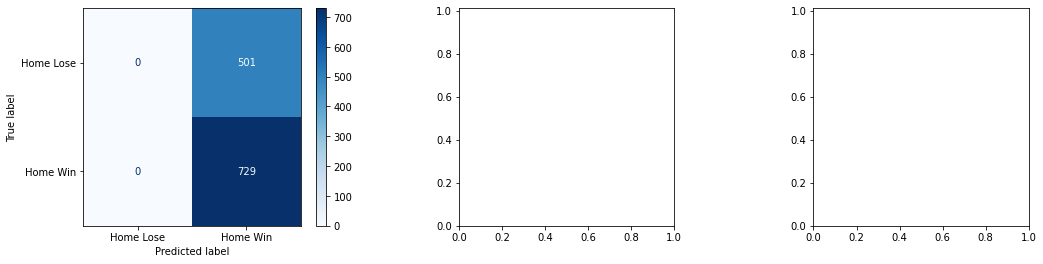

In [315]:
y_home = np.ones((df_test.shape[0],))
run_metrics(y_home, df_test['HOME_WIN'], cf_only=True)

## Always pick the team who won last matchup
Pick the team who won the last matchup, if no previous matchup exists pick the home team.

In [316]:
df_test['H_WON_LAST'] = df_test.apply(ProcessFeatures._home_won_last, args=[{}], axis=1)
    
# Feature validation
# matchup = get_matchup_games(df, 1610612739, 1610612766)
# matchup[['A_ID', 'H_ID', 'HOME_WIN', 'H_WON_LAST']]

F1 = 0.5387556943017995
n games = 1230


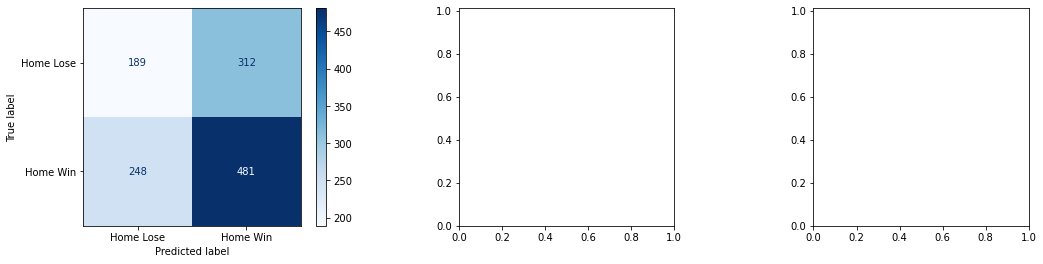

In [317]:
y_last_win = df_test['H_WON_LAST']
run_metrics(y_last_win, df_test['HOME_WIN'], cf_only=True)

## Always pick the series leader
Pick Home team if the series is tied

In [318]:
df_test['H_LEADER'] = df_test.apply(ProcessFeatures._home_series_leader, args=[defaultdict(list)], axis=1)

# Feature validation
# matchup = get_matchup_games(df, 1610612739, 1610612766)
# matchup[['A_ID', 'H_ID', 'HOME_WIN', 'H_LEADER']]

F1 = 0.5605965466967578
n games = 1230


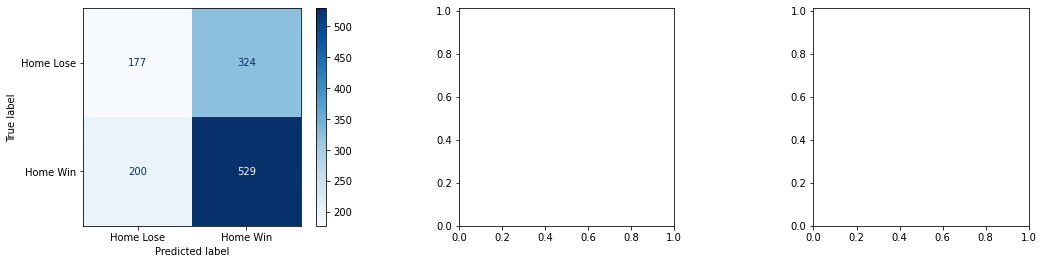

In [319]:
y_series_leader = df_test['H_LEADER']
run_metrics(y_series_leader, df_test['HOME_WIN'], cf_only=True)

## Data Prep

In [488]:
# load training data
df_train = load_season('2017-full.csv')
df_test = load_season('2018-full.csv')

adv_cols = ['DEF_RATING', 'OFF_RATING', 'TS_PCT', 'EFG_PCT',
            'PASS', 'PACE', 'TCHS', 'TM_TOV_PCT', 'CFGM', 
           'CFGA', 'UFGM', 'UFGA', 'DIST', ]
trad_cols = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 
             'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS', 'PLUS_MIN']


# ADVANCED FEATURES
pf = ProcessFeatures(adv_cols)
df_train_adv = pf.fit_transform(df_train)
df_test_adv = pf.transform(df_test)

# NORMALIZATION
# scaler = StandardScaler()
# df_train_adv[:, :len(pf.avg_cols)] = scaler.fit_transform(df_train_adv[:, :len(pf.avg_cols)])
# df_test_adv[:, :len(pf.avg_cols)] = scaler.transform(df_test_adv[:, :len(pf.avg_cols)])

X_train_adv, y_train_adv = df_train_adv[:, :-1], df_train_adv[:, -1]
X_test_adv, y_test_adv = df_test_adv[:, :-1], df_test_adv[:, -1]


# TRADITIONAL FEATURES
pf_trad = ProcessFeatures(trad_cols)
df_train_trad = pf_trad.fit_transform(df_train)
df_test_trad = pf_trad.transform(df_test)

X_train_trad, y_train_trad = df_train_trad[:, :-1], df_train_trad[:, -1]
X_test_trad, y_test_trad = df_test_trad[:, :-1], df_test_trad[:, -1]

# Linear Regression Model

In [489]:
lr = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=STATE)
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [1.0, 0.8, 0.5],
}

clf_1 = GridSearchCV(estimator=lr, param_grid=lr_params, cv=5, scoring='f1', n_jobs=-1)
clf_1.fit(X_train_adv, y_train_adv)
clf_1.best_params_

{'C': 0.8, 'penalty': 'l1'}

F1 = 0.6486441131051364
n games = 1065


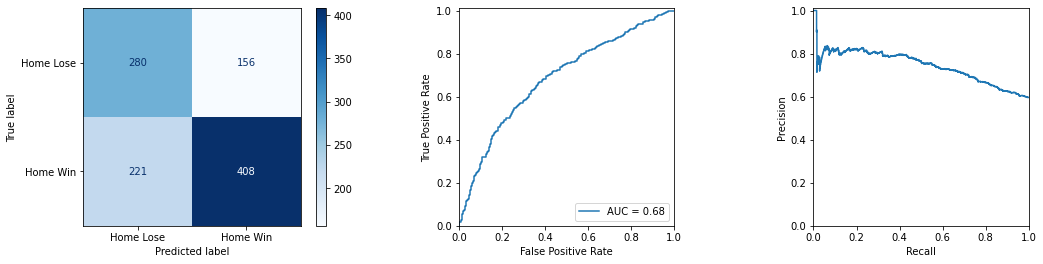

In [490]:
y_score_1 = clf_1.predict_proba(X_test_adv)
y_pred_1 = (y_score_1[:, 1] >= 0.5).astype(int)
run_metrics(y_pred_1, y_test_adv, y_score=y_score_1[:, 1])

## Using only traditional stats

In [491]:
clf_2 = GridSearchCV(estimator=lr, param_grid=lr_params, scoring='f1', cv=5, n_jobs=-1)
clf_2.fit(X_train_trad, y_train_trad)
clf_2.best_params_

{'C': 1.0, 'penalty': 'l1'}

F1 = 0.6307264321484589
n games = 1065


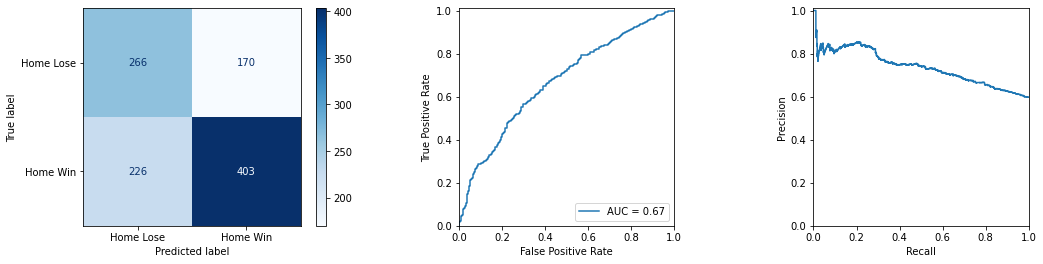

In [492]:
y_score_2 = clf_2.predict_proba(X_test_trad)
y_pred_2 = (y_score_2[:, 1] >= 0.5).astype(int)
run_metrics(y_pred_2, y_test_trad, y_score=y_score_2[:, 1])

# Random Forest

In [493]:
rf = RandomForestClassifier(class_weight='balanced', random_state=STATE)
rf_params = {
    'n_estimators': [100, 300],
    'min_samples_leaf': [1, 3]
}

# discretize continuos features!!
kbins = KBinsDiscretizer(encode='ordinal', strategy='kmeans', n_bins=3)
df_train_adv[:, :len(pf.avg_cols)] = kbins.fit_transform(df_train_adv[:, :len(pf.avg_cols)])
df_test_adv[:, :len(pf.avg_cols)] = kbins.transform(df_test_adv[:, :len(pf.avg_cols)])

clf_3 = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='f1', n_jobs=-1)
clf_3.fit(X_train_adv, y_train_adv)
clf_3.best_params_

{'min_samples_leaf': 1, 'n_estimators': 300}

F1 = 0.6210101757812438
n games = 1065


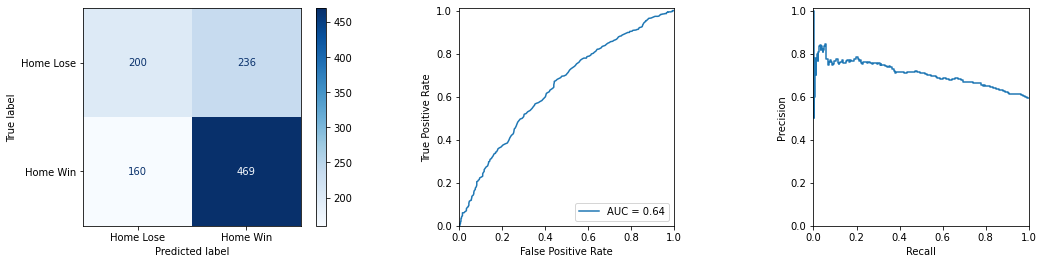

In [494]:
y_score_3 = clf_3.predict_proba(X_test_adv)
y_pred_3 = (y_score_3[:, 1] >= 0.5).astype(int)
run_metrics(y_pred_3, y_test_adv, y_score=y_score_3[:, 1])

## Feature Importances!!

In [495]:
f_imp_idx = list(reversed(np.argsort(clf_3.best_estimator_.feature_importances_)))[:10]
f_imp_sorted = sorted(clf_3.best_estimator_.feature_importances_, reverse=True)[:10]

for feature, importance in zip(pf.columns[f_imp_idx], f_imp_sorted):
    print(feature, importance)

OFF_RATING 0.04752141611680732
DEF_RATING 0.044639762213201116
PACE 0.039332495209473385
TM_TOV_PCT 0.0391957892770903
CFGM 0.036685423793729424
UFGA 0.03487930420439898
TS_PCT 0.03408115736796776
EFG_PCT 0.033620948500588145
CFGA 0.03343334711693183
UFGM 0.032903727144338105


## Using only traditional stats

In [496]:
# discretize continuos features!!
kbins = KBinsDiscretizer(encode='ordinal', strategy='kmeans', n_bins=3)
df_train_trad[:, :len(pf_trad.avg_cols)] = kbins.fit_transform(df_train_trad[:, :len(pf_trad.avg_cols)])
df_test_trad[:, :len(pf_trad.avg_cols)] = kbins.transform(df_test_trad[:, :len(pf_trad.avg_cols)])

clf_4 = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='f1', n_jobs=-1)
clf_4.fit(X_train_trad, y_train_trad)
clf_4.best_params_

{'min_samples_leaf': 1, 'n_estimators': 300}

F1 = 0.6186294966144112
n games = 1065


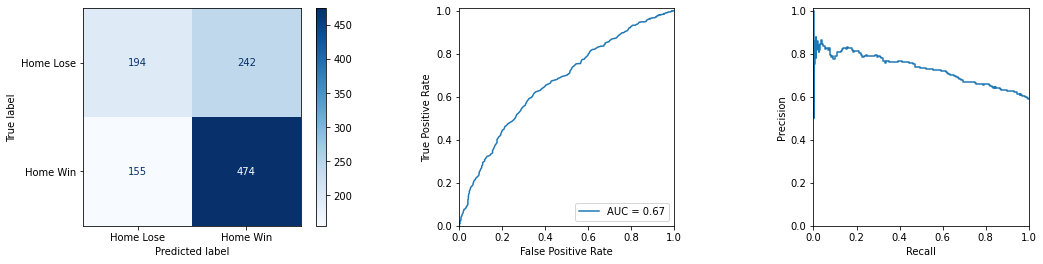

In [497]:
y_score_4 = clf_4.predict_proba(X_test_trad)
y_pred_4 = (y_score_4[:, 1] >= 0.5).astype(int)
run_metrics(y_pred_4, y_test_trad, y_score=y_score_4[:, 1])

## Feature Importances (traditional stats)

In [498]:
f_imp_idx_2 = list(reversed(np.argsort(clf_4.best_estimator_.feature_importances_)))[:10]
f_imp_sorted_2 = sorted(clf_4.best_estimator_.feature_importances_, reverse=True)[:10]

for feature, importance in zip(pf_trad.columns[f_imp_idx_2], f_imp_sorted_2):
    print(feature, importance)

PLUS_MIN 0.060137561221470646
PTS 0.04259105104440913
STL 0.038490788165585564
FG_PCT 0.038210640379176576
TO 0.0382045486542242
FG3_PCT 0.03804552333487272
FT_PCT 0.0378671111652567
BLK 0.03773323599470265
PF 0.03768564620770792
DREB 0.03739820847381472


# Neural Net

In [499]:
from tensorflow import keras
import tensorflow as tf
K = keras.backend

tf.random.set_seed(STATE)

def f1(y_true, y_pred):
    """Use keras backend to compute f1 metric"""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [500]:
# scale data between 0 and 1
mm_scaler = MinMaxScaler()
X_train_adv_s = mm_scaler.fit_transform(X_train_adv)
X_test_adv_s = mm_scaler.transform(X_test_adv)

# create a validation set
X_train_adv_s, X_val_adv_s, y_train_adv_s, y_val_adv_s = train_test_split(X_train_adv_s, y_train_adv, 
                                                                          random_state=STATE)

# X_train_trad_s = mm_scaler.fit_transform(X_train_trad)
# X_test_trad_s = mm_scaler.transform(X_test_trad)

In [524]:
ann_1 = keras.models.Sequential([
    keras.layers.Input(shape=(75,)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(32, activation='selu'),
#     keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(16, activation='selu'),
#     keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(1, activation='sigmoid'),
])

METRICS = [keras.metrics.BinaryAccuracy(name='accuracy'), f1]
early_stop = keras.callbacks.EarlyStopping(patience=15, 
                                           restore_best_weights=True)

ann_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

In [525]:
ann_1.fit(X_train_adv_s, y_train_adv_s, epochs=100, 
          validation_data=(X_val_adv_s, y_val_adv_s), callbacks=[early_stop])

Epoch 1/100
25/25 [==============================] - 0s 8ms/step - loss: 0.9004 - accuracy: 0.4843 - f1: 0.5255 - val_loss: 0.6876 - val_accuracy: 0.6015 - val_f1: 0.7391
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7023 - accuracy: 0.5684 - f1: 0.6158 - val_loss: 0.6538 - val_accuracy: 0.6353 - val_f1: 0.7477
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6368 - accuracy: 0.6575 - f1: 0.7101 - val_loss: 0.6415 - val_accuracy: 0.6504 - val_f1: 0.7464
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5999 - accuracy: 0.6650 - f1: 0.7177 - val_loss: 0.6345 - val_accuracy: 0.6579 - val_f1: 0.7415
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5804 - accuracy: 0.6926 - f1: 0.7436 - val_loss: 0.6298 - val_accuracy: 0.6654 - val_f1: 0.7390
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5757 - accuracy: 0.7001 - f1: 0.7464 - val_loss: 0.6270 - val_accuracy

F1 = 0.6157685737196679
n games = 1065


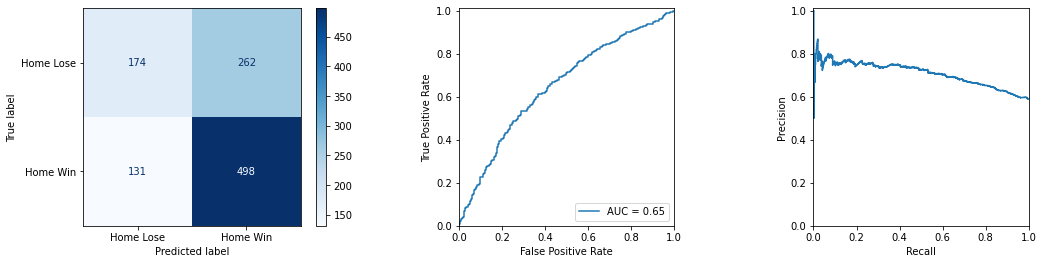

In [526]:
ann_1_score = ann_1.predict(X_test_adv_s)
ann_1_pred = (ann_1_score > 0.5).astype(int)

run_metrics(ann_1_pred, y_test_adv, y_score=ann_1_score)

# Ensemble Experiment

F1 = 0.6402469077626405
n games = 1065


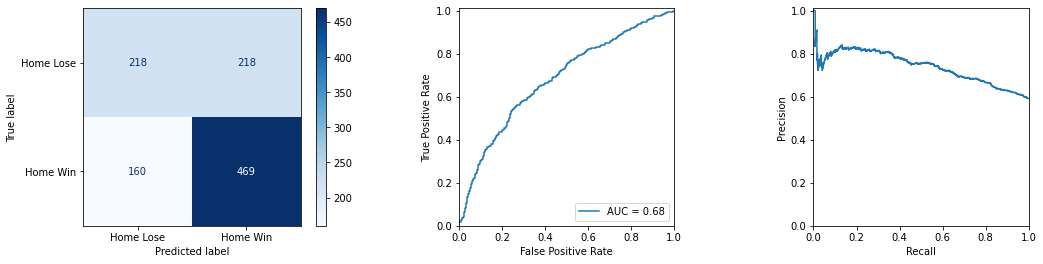

In [527]:
# get the best versions of each model
lr_score = y_score_1[:, 1]
rf_score = y_score_4[:, 1] # traditional stats!!
ann_score = ann_1_score

ensemble_score = np.hstack([
    lr_score.reshape((-1, 1)), 
    rf_score.reshape((-1, 1)),
    ann_score
])

ensemble_score = np.mean(ensemble_score, axis=1) # soft voting
ensemble_pred = (ensemble_score >= 0.5).astype(int)
run_metrics(ensemble_pred, y_test_adv, y_score=ensemble_score)